In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm


In [14]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))

    return s

# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0.

    return w, b


# propagate
def propagate(w, b, X, Y):
    m = X.shape[1]

    # Forward propagation
    Z = np.dot(w.T, X) + b
    A = 1 / (1 + np.exp(-Z))

    # Compute cost
    epsilon = 1e-10  # Small epsilon value to avoid division by zero
    clipped_A = np.clip(A, epsilon, 1 - epsilon)  # Clip values to avoid log(0) or log(1)
    cost = -(1./m) * np.sum(Y * np.log(clipped_A) + (1 - Y) * np.log(1 - clipped_A), axis=1)

    # Backward propagation
    dz = A - Y
    dw = (1./m) * np.dot(X, dz.T)
    db = (1./m) * np.sum(dz)

    grads = {"dw": dw, "db": db}
    return grads, cost


# optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """

    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation
        grads, cost = propagate(w,b,X,Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs


### 1. Applying logreg

In [15]:
data = pd.read_csv('bioresponse.csv')

X = data.drop('Activity', axis=1)
Y = data['Activity']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

w = np.zeros((X_train.shape[1], 1))
b = 0

num_iterations = 1000
learning_rate = 0.01

params, grads, costs = optimize(w, b, X_train.T, Y_train.values.reshape(1, -1), num_iterations, learning_rate, print_cost=True)

w = params['w']
b = params['b']

predictions = (np.dot(w.T, X_test.T) + b > 0.5).astype(int)

accuracy = np.mean(predictions == Y_test.values.reshape(1, -1))
print("Test accuracy: {:.2f}%".format(accuracy * 100))


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.470840
Cost after iteration 200: 0.426780
Cost after iteration 300: 0.402530
Cost after iteration 400: 0.386057
Cost after iteration 500: 0.373656
Cost after iteration 600: 0.363736
Cost after iteration 700: 0.355476
Cost after iteration 800: 0.348402
Cost after iteration 900: 0.342218
Test accuracy: 75.37%


### 2. Applying logreg with sgd and adam optimizers

In [29]:
def optimize_sgd_batch(w, b, X, Y, num_iterations, learning_rate, batch_size=32, print_cost=False):
    costs = []
    m = X.shape[1]  # number of training examples

    for i in range(num_iterations):
        # Shuffle the data and split into batches
        permutation = np.random.permutation(m)
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation]

        for j in range(0, m, batch_size):
            # Get mini-batch
            x_batch = shuffled_X[:, j:j+batch_size]
            y_batch = shuffled_Y[:, j:j+batch_size]

            # Cost and gradient calculation for the mini-batch
            grads, cost = propagate(w, b, x_batch, y_batch)

            # Retrieve derivatives from grads
            dw = grads["dw"]
            db = grads["db"]

            # Update rule
            w -= learning_rate * dw
            b -= learning_rate * db

        # Calculate cost for the entire training set
        if i % 100 == 0:
            _, cost = propagate(w, b, X, Y)
            costs.append(cost)
            if print_cost:
                print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}

    return params, grads, costs

def optimize_adam(w, b, X, Y, num_iterations, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, print_cost=False):
    costs = []
    m = X.shape[1]  # number of training examples
    t = 1
    v_dw, v_db = 0, 0
    s_dw, s_db = 0, 0

    for i in range(num_iterations):
        t+=1
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]

        # Update biased first moment estimate
        v_dw = beta1 * v_dw + (1 - beta1) * dw
        v_db = beta1 * v_db + (1 - beta1) * db

        # Update biased second moment estimate
        s_dw = beta2 * s_dw + (1 - beta2) * (dw ** 2)
        s_db = beta2 * s_db + (1 - beta2) * (db ** 2)

        # Correct bias in first moment
        v_dw_corrected = v_dw / (1 - beta1**t)
        v_db_corrected = v_db / (1 - beta1**t)

        # Correct bias in second moment
        s_dw_corrected = s_dw / (1 - beta2**t)
        s_db_corrected = s_db / (1 - beta2**t)

        # Update parameters
        w -= learning_rate * v_dw_corrected / (np.sqrt(s_dw_corrected) + epsilon)
        b -= learning_rate * v_db_corrected / (np.sqrt(s_db_corrected) + epsilon)


        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}

    return params, grads, costs


In [31]:
params_sgd, _, costs_sgd = optimize_sgd_batch(np.zeros((X_train.shape[1], 1)), 0, X_train.T, Y_train.values.reshape(1, -1), num_iterations=1000, learning_rate=0.01, batch_size=32, print_cost=True)


Cost after iteration 0: 0.498269
Cost after iteration 100: 0.228961
Cost after iteration 200: 0.197705
Cost after iteration 300: 0.181215
Cost after iteration 400: 0.169480
Cost after iteration 500: 0.161149
Cost after iteration 600: 0.153891
Cost after iteration 700: 0.148325
Cost after iteration 800: 0.143346
Cost after iteration 900: 0.139337


In [30]:
params_adam, _, costs_adam = optimize_adam(np.zeros((X_train.shape[1], 1)), 0, X_train.T, Y_train.values.reshape(1, -1), num_iterations=1000, learning_rate=0.01, print_cost=True)


Cost after iteration 0: 0.693147


Cost after iteration 100: 0.232566
Cost after iteration 200: 0.188866
Cost after iteration 300: 0.165093
Cost after iteration 400: 0.149041
Cost after iteration 500: 0.136949
Cost after iteration 600: 0.127229
Cost after iteration 700: 0.119092
Cost after iteration 800: 0.112097
Cost after iteration 900: 0.105968


### 3. Plot learning curves and then fit models with different LR's

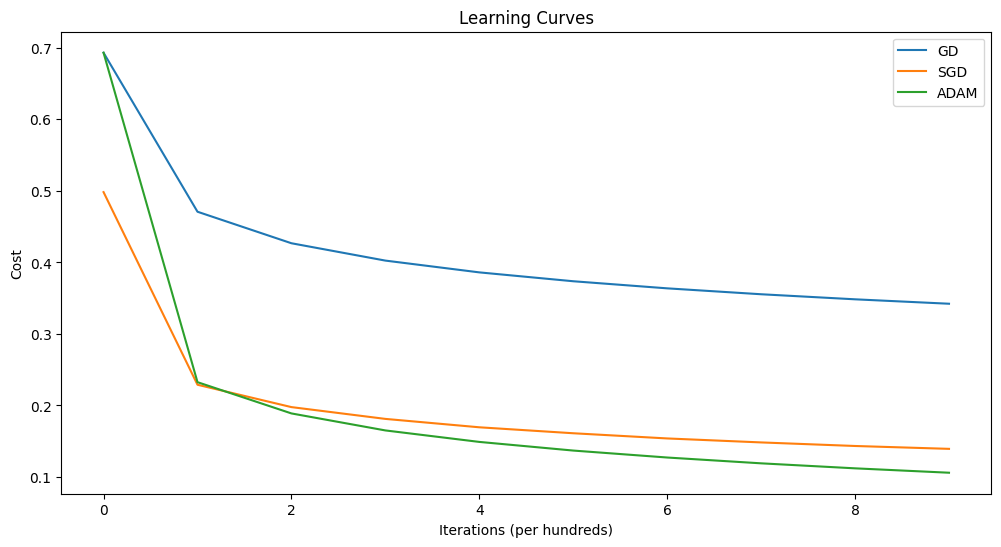

In [32]:
# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(costs, label="GD")
plt.plot(costs_sgd, label="SGD")
plt.plot(costs_adam, label="ADAM")
plt.xlabel("Iterations (per hundreds)")
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()
plt.show()


In [38]:
# Define a list of learning rates to try
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]

# Initialize dictionaries to store models and their corresponding costs
models = {}
costs = {}

# Fit models for different learning rates
for lr in tqdm(learning_rates):
    # Initialize weights and biases
    initial_w = np.zeros((X_train.shape[1], 1))
    initial_b = 0

    # Train the model using GD with 300 iterations
    params_gd, _, costs_gd = optimize(initial_w, initial_b, X_train.T, Y_train.values.reshape(1, -1), num_iterations=300, learning_rate=lr)

    # Store the model parameters and costs
    models[f'GD_LR_{lr}'] = params_gd
    costs[f'GD_LR_{lr}'] = costs_gd

    # Train the model using SGD with batch size 32 and 300 iterations
    params_sgd, _, costs_sgd = optimize_sgd_batch(initial_w, initial_b, X_train.T, Y_train.values.reshape(1, -1), num_iterations=300, learning_rate=lr, batch_size=32)

    # Store the model parameters and costs
    models[f'SGD_LR_{lr}'] = params_sgd
    costs[f'SGD_LR_{lr}'] = costs_sgd

    # Train the model using ADAM with 300 iterations
    params_adam, _, costs_adam = optimize_adam(initial_w, initial_b, X_train.T, Y_train.values.reshape(1, -1), num_iterations=300, learning_rate=lr)

    # Store the model parameters and costs
    models[f'ADAM_LR_{lr}'] = params_adam
    costs[f'ADAM_LR_{lr}'] = costs_adam


  0%|          | 0/5 [00:00<?, ?it/s]

### 4. Comparing accuracy of fitted models

In [39]:
# Evaluate models on the validation set and compare their performance
best_model = None
best_accuracy = 0

for model_name, params in models.items():
    w, b = params['w'], params['b']

    # Predict on validation set
    predictions = sigmoid(np.dot(w.T, X_test.T) + b)
    predictions = predictions > 0.5  # Convert probabilities to binary predictions

    # Calculate accuracy
    accuracy = np.mean(predictions == Y_test.values.reshape(1, -1))
    print(f"Model: {model_name}, Validation Accuracy: {accuracy}")

    # Update best model if the current model has higher accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model_name

print(f"\nBest Model: {best_model}, Validation Accuracy: {best_accuracy}")


Model: GD_LR_0.1, Validation Accuracy: 0.6993603411513859
Model: SGD_LR_0.1, Validation Accuracy: 0.7110874200426439
Model: ADAM_LR_0.1, Validation Accuracy: 0.7121535181236673
Model: GD_LR_0.01, Validation Accuracy: 0.7142857142857143
Model: SGD_LR_0.01, Validation Accuracy: 0.7153518123667377
Model: ADAM_LR_0.01, Validation Accuracy: 0.7142857142857143
Model: GD_LR_0.001, Validation Accuracy: 0.7420042643923241
Model: SGD_LR_0.001, Validation Accuracy: 0.7398720682302772
Model: ADAM_LR_0.001, Validation Accuracy: 0.7366737739872068
Model: GD_LR_0.0001, Validation Accuracy: 0.7750533049040512
Model: SGD_LR_0.0001, Validation Accuracy: 0.779317697228145
Model: ADAM_LR_0.0001, Validation Accuracy: 0.7771855010660981
Model: GD_LR_1e-05, Validation Accuracy: 0.732409381663113
Model: SGD_LR_1e-05, Validation Accuracy: 0.7377398720682303
Model: ADAM_LR_1e-05, Validation Accuracy: 0.7356076759061834

Best Model: SGD_LR_0.0001, Validation Accuracy: 0.779317697228145
